# Kaggle Competition
## Javier Palomares

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [17]:
train = pd.read_csv('./input/train_final.csv')
test = pd.read_csv('./input/test_final.csv')

In [18]:
train.head()

,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,1,25884,1,33.63,118596,1,0,118595,125738,...,1945,118450,119184,1,121372,1,1,1,2,1
1,2,1,34346,1,10.62,118041,1,0,117902,130913,...,15385,117945,292795,1,259173,1,1,1,1,1
2,3,1,34923,1,1.77,118327,1,0,117961,124402,...,7547,118933,290919,1,118784,1,1,1,1,1
3,4,1,80926,1,30.09,118300,1,0,117961,301218,...,4933,118458,118331,1,307024,1,1,1,2,1
4,5,1,4674,1,1.77,119921,1,0,119920,302830,...,13836,142145,4673,1,128230,1,1,1,620,1


In [19]:
train.shape

(16383, 26)

In [20]:
y = train.Y

(array([  948.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15435.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

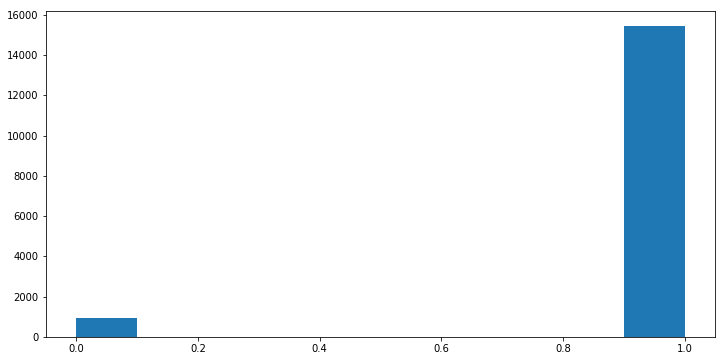

In [21]:
plt.hist(y)

It looks like the y variable is binary

In [29]:
x_train = train.loc[:,'f1':'f24']
x_test = test.loc[:,'f1':'f24']

### Data Preprocessing

In [32]:
# get the numberical features 
numeric_feats = x_train.dtypes[x_train.dtypes != "object"].index
print(numeric_feats)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24'],
      dtype='object')


All features are numeric